<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%shell
pip install kaggle
export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=6ba3f466a063e70addd26514bb2cf41d

kaggle datasets download paultimothymooney/chest-xray-pneumonia
unzip -q chest-xray-pneumonia.zip

git clone https://github.com/ieee8023/covid-chestxray-dataset.git

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace chest_xray/__MACOSX/chest_xray/test/._NORMAL? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


CalledProcessError: ignored

In [0]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import random
import matplotlib.image as mpimg 
from PIL import Image

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # tf.compat.v1.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

In [3]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

root = 'chest_xray/chest_xray/train/'
normal_xray = get_dataset(root+'NORMAL/', 'normal')
pneumonia_xray = get_dataset(root+'PNEUMONIA/', 'pneumonia')
print(len(normal_xray), normal_xray[0:5])
print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
metadata_path='covid-chestxray-dataset/metadata.csv'
srcpath = 'covid-chestxray-dataset/images/'
df=pd.read_csv(metadata_path)
covid_patients=df['finding']=='COVID-19'
PA=df['view']=='PA'
PA_covid=df[covid_patients & PA]
covid_xray = [[srcpath + files, 'covid'] for files in PA_covid['filename']]
print(len(covid_xray), covid_xray[0:5])

random.shuffle(normal_xray)
random.shuffle(pneumonia_xray)
random.shuffle(covid_xray)

# Generate balanced randomized dataset
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1
dataset = normal_xray[0:min_size] + covid_xray[0:min_size] + pneumonia_xray[0:min_size]
random.shuffle(dataset)

print(len(dataset), dataset[0:5])

# Load dataset into panda frames
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
print(df)

X = df['X']
y = df['y']

classes= y.unique()
print(classes)

# Split the dataset into train, valid, and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print("Approx. 64% train, 16% validation and 20% test split")
print(len(df), len(X_train), len(X_val), len(X_test))

!rm -rf dataset/
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = 'dataset/'+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    # print(_X, path)
    shutil.copy(_X, path)

!tar -czf dataset.tar.gz dataset/

1341 [['chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1252-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/IM-0291-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0851-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0386-0001.jpeg', 'normal'], ['chest_xray/chest_xray/train/NORMAL/IM-0242-0001.jpeg', 'normal']]
3875 [['chest_xray/chest_xray/train/PNEUMONIA/person23_bacteria_90.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person1361_virus_2344.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person545_bacteria_2288.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person757_virus_1385.jpeg', 'pneumonia'], ['chest_xray/chest_xray/train/PNEUMONIA/person1246_bacteria_3202.jpeg', 'pneumonia']]
127 [['covid-chestxray-dataset/images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'covid'], ['covid-chestxray-dataset/images/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietna

In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = True) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    print("losess", len(losses))
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        print("DONE")
        
    return lr_to_use

distribution 241 61 76
classes ['covid', 'normal', 'pneumonia']


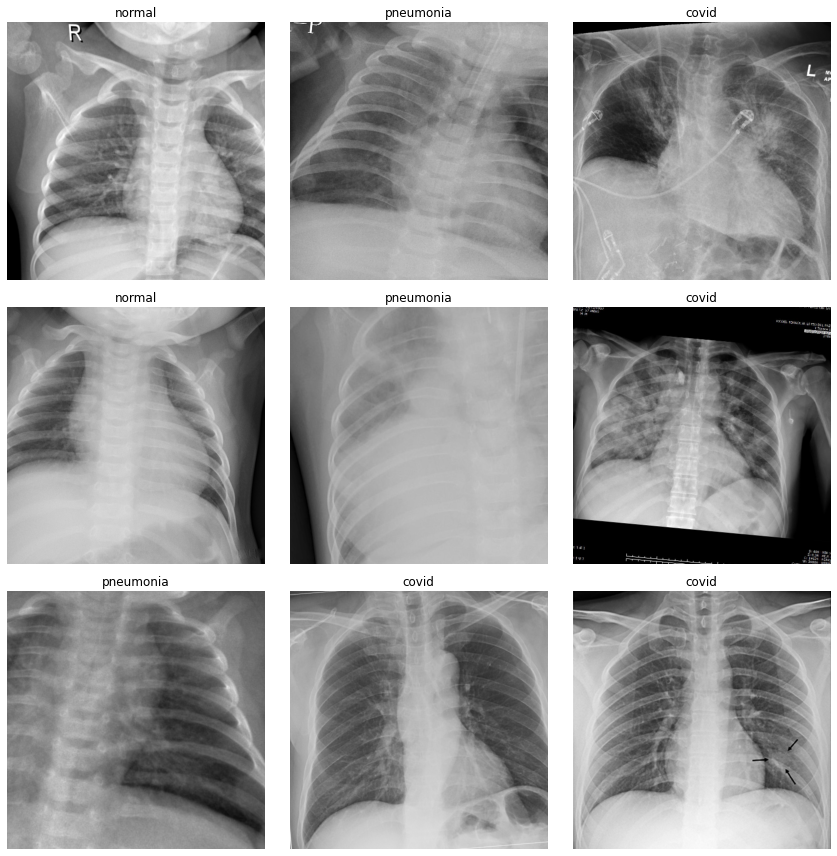

In [5]:
#sample of our images with labels
def stage(data):
  print("distribution", len(data.train_ds),len(data.valid_ds),len(data.test_ds.x))
  print("classes", data.classes)
  data.show_batch(20)
  return None

tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=15.0, max_lighting=0.1, max_zoom=1.05)#, max_warp=0.

data = ImageDataBunch.from_folder('dataset', train="train", valid='val',test='test',
        ds_tfms=get_transforms(tfms), bs=9, size=512, num_workers=4).normalize()
stage(data)

In [0]:
precision=Precision()
recall=Recall()
AUC=AUROC()

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=(accuracy,precision,recall,AUC), callback_fns=[ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 2.29E-03


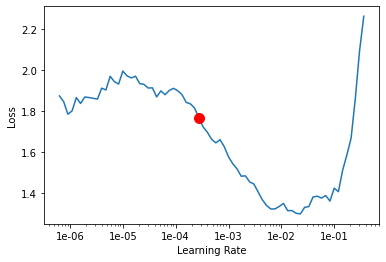

In [8]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
# lr_diff = 15 if len(learn.recorder.losses) > 15 else len(learn.recorder.losses) - 1
# print("lr_diff", lr_diff)
# lr = find_appropriate_lr(learn, lr_diff=lr_diff)
# print("find_appropriate_lr", lr)

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,1.252743,0.327386,0.868852,0.875082,0.876396,0.372180,00:35
1,0.876205,0.446519,0.934426,0.939855,0.939394,0.268170,00:32
2,0.867708,0.707002,0.885246,0.902564,0.883971,0.167920,00:32
3,0.672954,0.292627,0.918033,0.924242,0.924242,0.353383,00:32
4,0.459385,0.167815,0.967213,0.967460,0.969697,0.429825,00:32
5,0.415512,0.439652,0.950820,0.953030,0.954545,0.417293,00:33
6,0.321304,0.393784,0.950820,0.950710,0.952153,0.373434,00:33
7,0.252640,0.372991,0.934426,0.935486,0.937002,0.373434,00:32


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


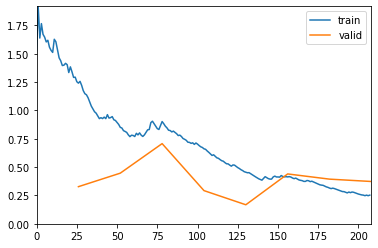

In [11]:
learn.fit_one_cycle(5, max_lr=slice(1.32E-03))

In [0]:
from operator import itemgetter
def eval(imgsize, bs):
  # results = [_y == str(learn.predict(open_image(_X))[0]) for _X, _y in zip(X_test, y_test)]
  # print("Accuracy", np.sum(np.array(results))/len(results)*100, "%")
  fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10), dpi=200)

  for _X, _y, ax2 in zip(X_test[15:21], y_test[15:21], axes.flatten()):
    pred = learn.predict(open_image(_X))
    results = [(classes[i], x.item()*100) for i, x in enumerate(pred[2])]
    results = sorted(results, key=itemgetter(1), reverse=True)
    # print(results)
    results = " ".join(["%s: %.2f%%" % (label, percent) for label, percent in results])
    # print(results)
    ax2.axis('off')
    ax2.set_title("%s\n%s" % (_y,results)) #pred[0]
    # mpimg_img = mpimg.imread(_X)
    ax2.imshow(Image.open(os.path.join(_X)).convert(mode="LA").resize((imgsize,imgsize)))
  fig.suptitle("Ground truth\nPrediction", weight='bold', size=12)

  val = learn.validate()
  print("Validation Accuracy", val[1].item() * 100, "%")

  data_test = ImageDataBunch.from_folder('dataset', train="train", valid='test',
          ds_tfms=get_transforms(), bs=bs, size=imgsize, num_workers=4).normalize()
  val = learn.validate(data_test.valid_dl)
  # print(val)
  # print(learn.metrics)

  print("Test Accuracy", val[1].item() * 100, "%")

  interp = ClassificationInterpretation.from_learner(learn)
  interp.plot_confusion_matrix(dpi=200)
  
  interp.plot_top_losses(9)

Validation Accuracy 93.44262480735779 %


Test Accuracy 96.05262875556946 %


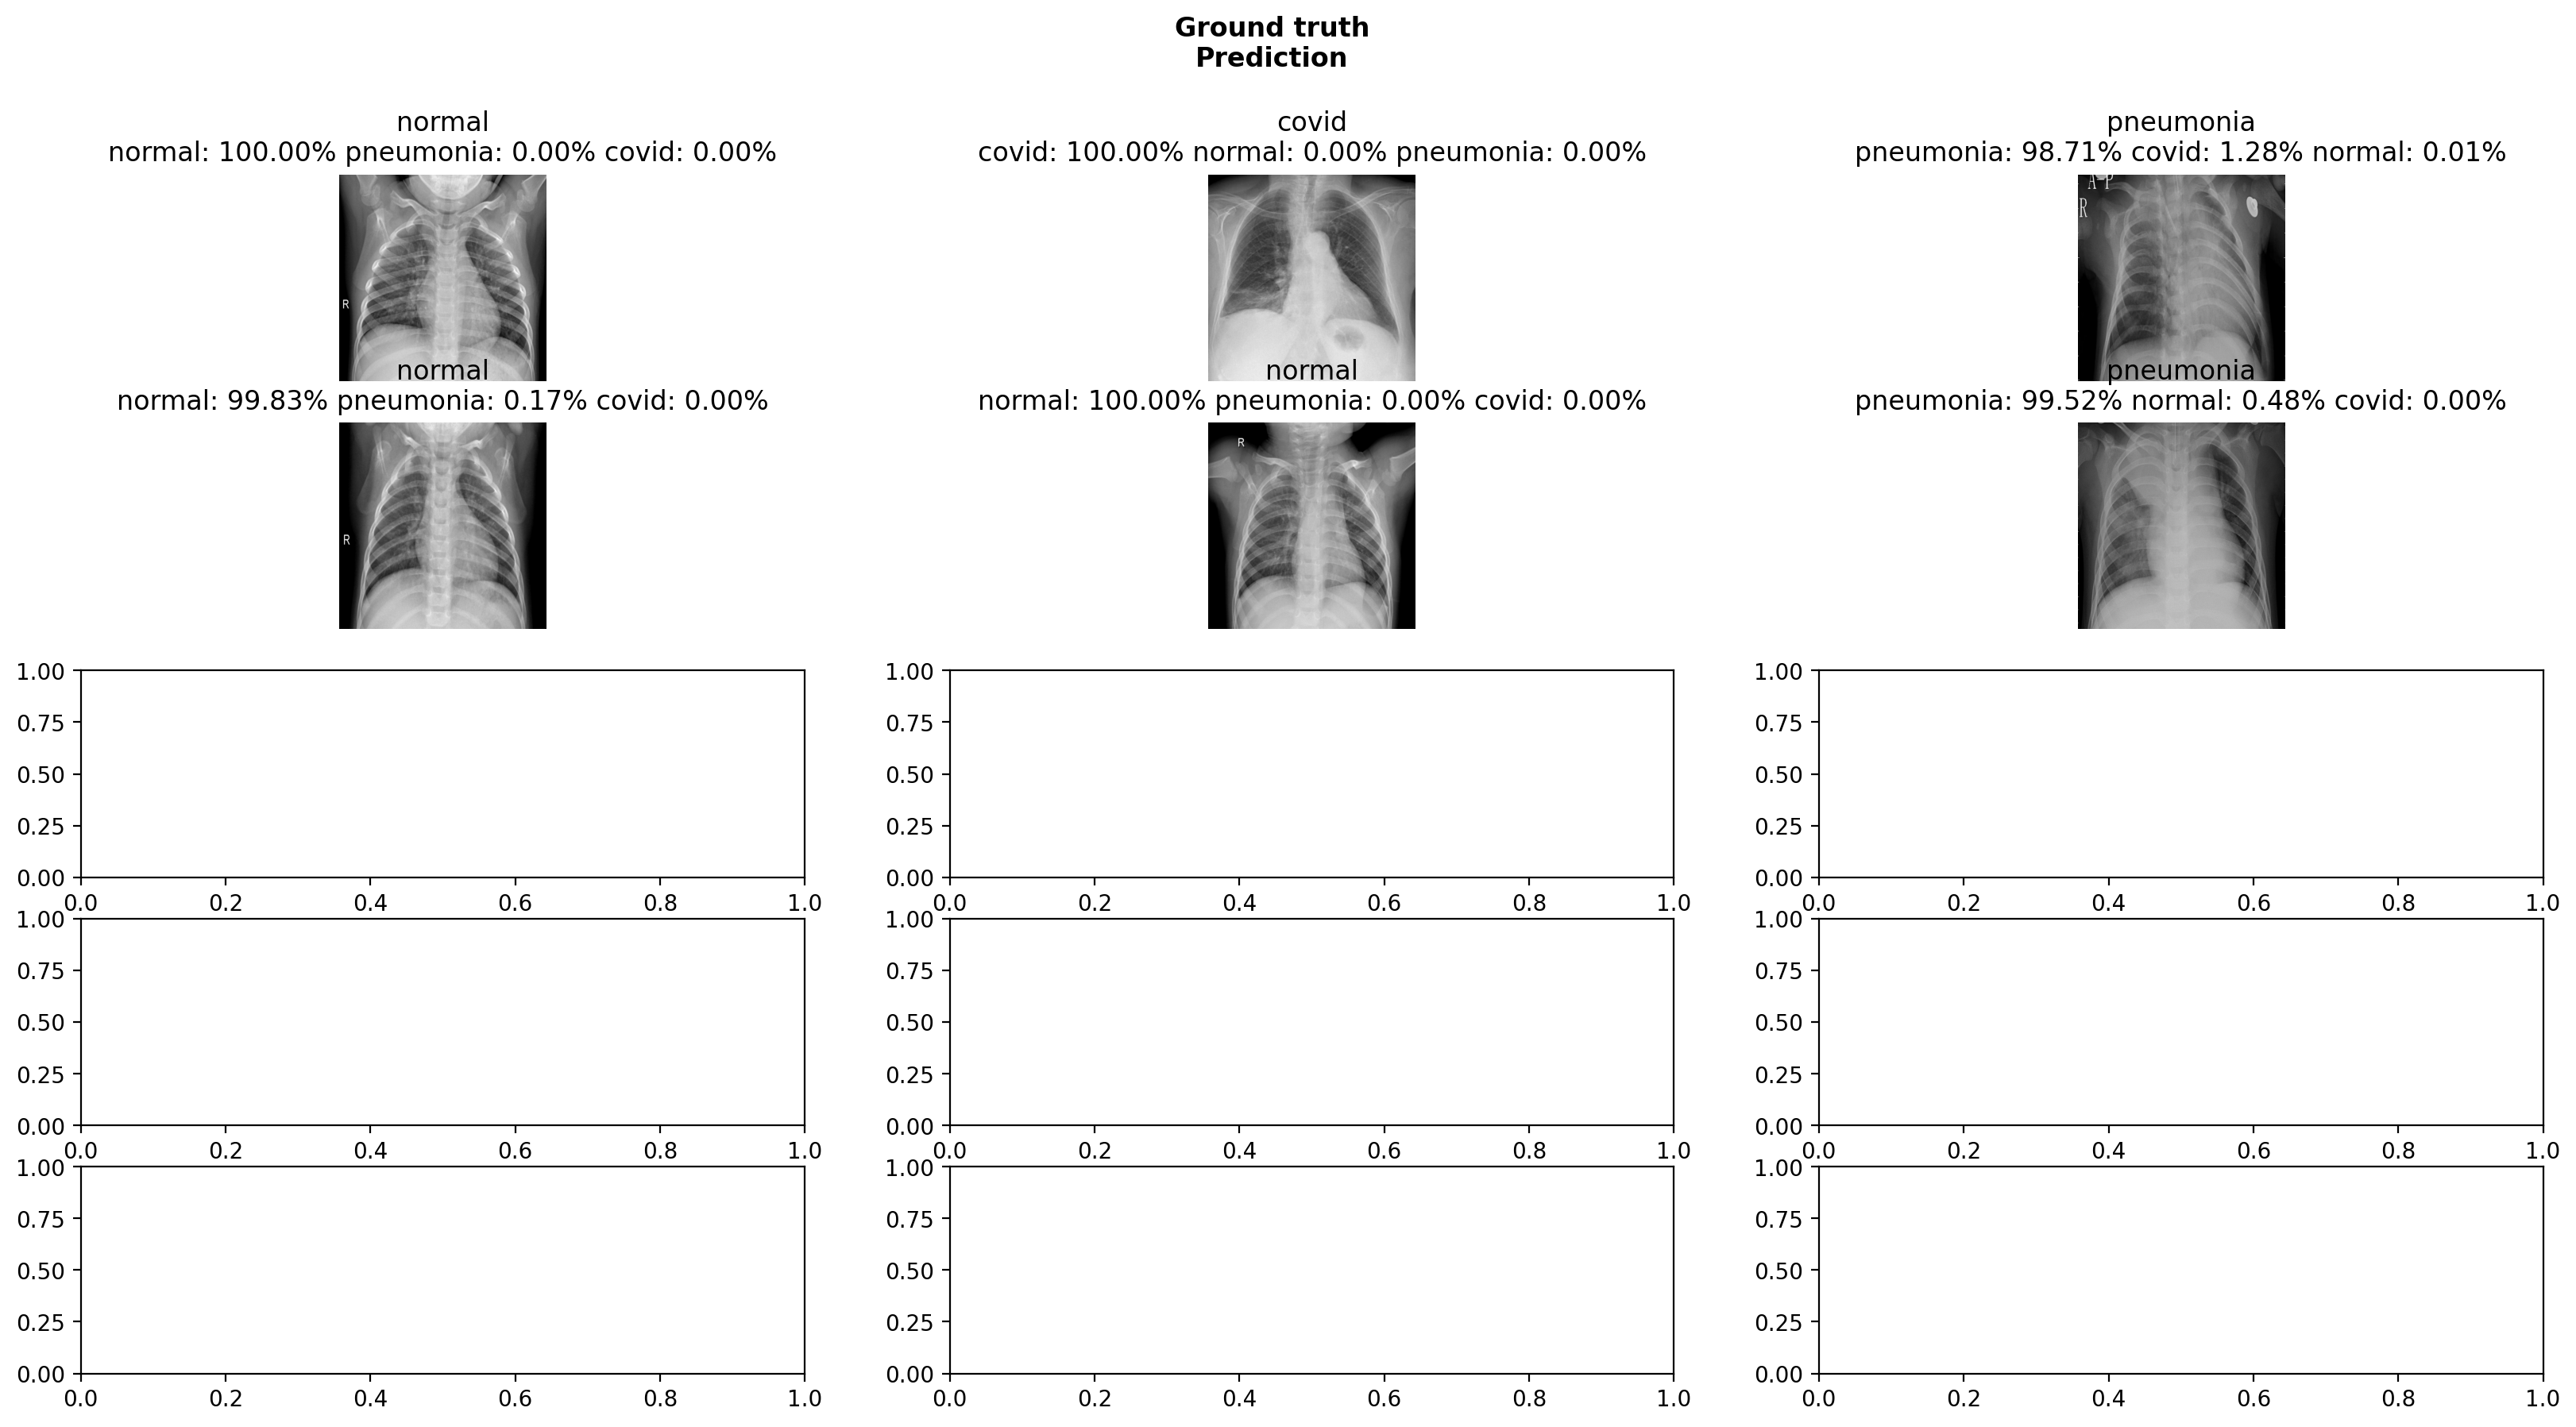

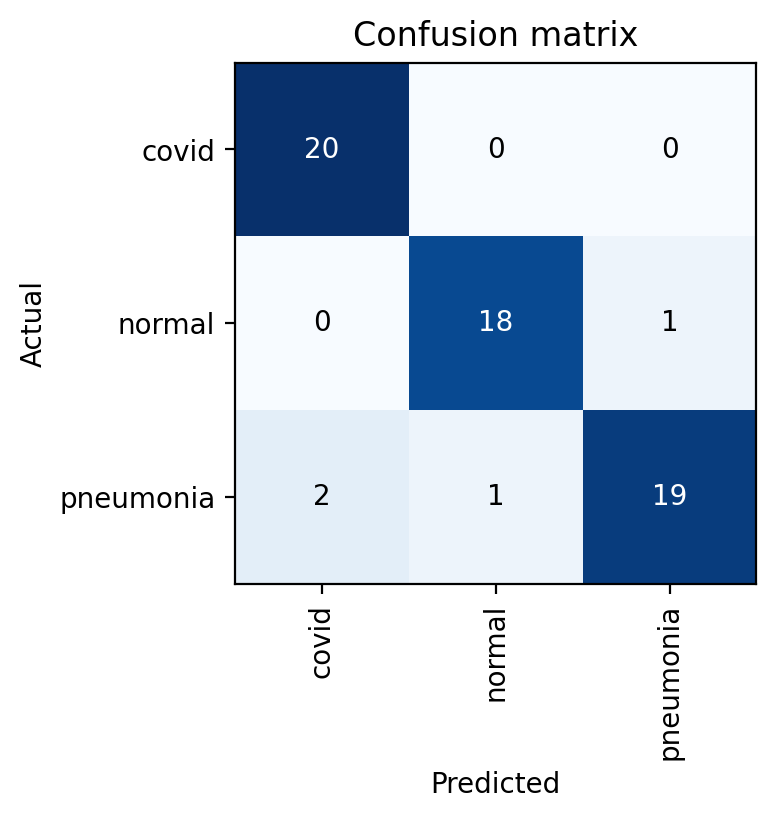

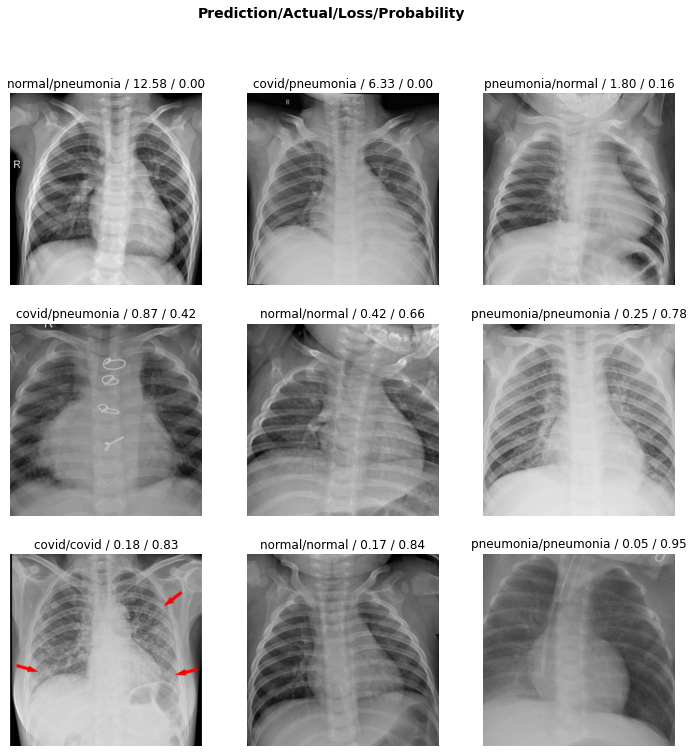

In [13]:
eval(imgsize=512, bs=8)

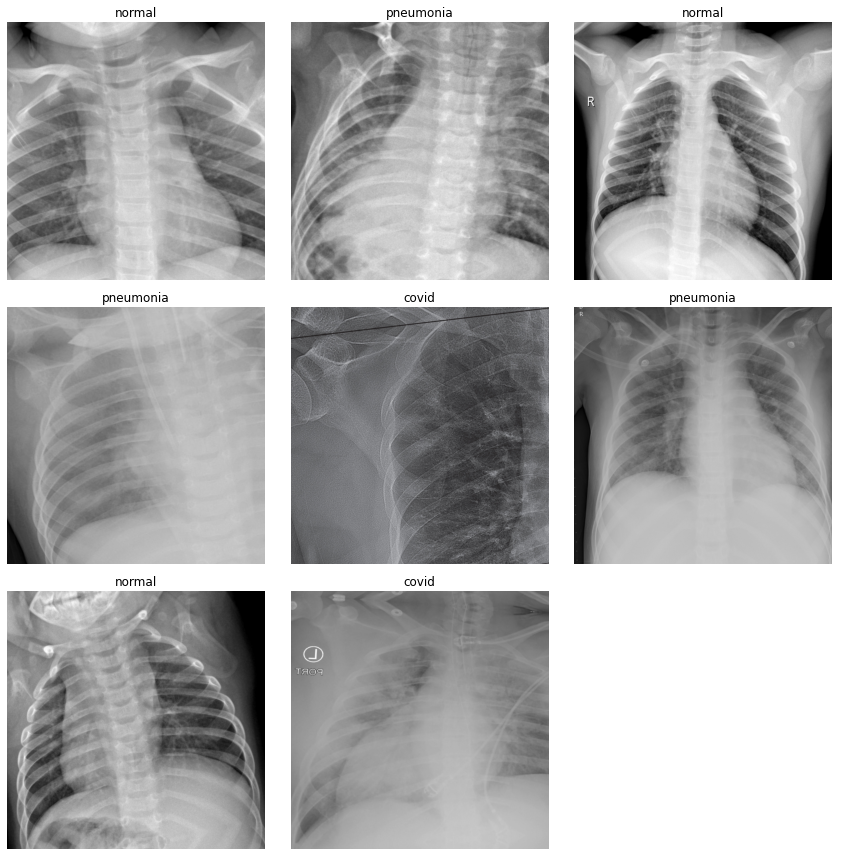

In [14]:
#Augument and upsize
data = ImageDataBunch.from_folder('dataset', train="train", valid='val',test='test',
        ds_tfms=tfms, bs=9, size=768, num_workers=4).normalize()
learn.data = data

data.train_ds[0][0].shape
data.show_batch()

In [16]:
# learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time


RuntimeError: ignored

In [0]:
# lr_diff = 15 if len(learn.recorder.losses) > 15 else len(learn.recorder.losses) -1
# print("lr_diff", lr_diff)
# lr = find_appropriate_lr(learn, lr_diff=lr_diff)
# print("find_appropriate_lr", lr)

In [17]:
learn.fit_one_cycle(5, max_lr=slice(7.59E-08))

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time


RuntimeError: ignored

In [0]:
eval(imgsize=768, bs=4)